## 1. Library Importing

In [19]:
import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import string # 표준 파이썬 문자열을 처리
import re
from sklearn.metrics.pairwise import cosine_similarity # 이를 나중에 사용하여 두 개의 문장이 얼마나 비슷한지를 결정합니다.
from sklearn.feature_extraction.text import TfidfVectorizer # Experience 2에서 단어 가방을 만드는 함수를 만들었던 것을 기억하십니까? 이 함수는 같은 일을 합니다!
import re

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # LogisticRegression import 추가

import os
import numpy as np
from google.colab import drive

## 2. Data Uploading

In [20]:
  # Colab에서 Google 드라이브를 마운트하기 위한 라이브러리

# 구글 드라이브 마운트
drive.mount('/content/drive')

def loadfile(path):
    X = []
    Y = []

    for label in ('0', '25', '50', '75', '100'):
        print("Loading text files for the label: " + label)

        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()

                # 레이블을 숫자로 변환
                if label == '0':
                    Y.append(0)
                elif label == '25':
                    Y.append(1)
                elif label == '50':
                    Y.append(2)
                elif label == '75':
                    Y.append(3)
                elif label == '100':
                    Y.append(4)

                # 텍스트 데이터를 X에 추가
                X.append(text)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_Son/'

# loadfile 함수 호출
X, Y = loadfile(directory_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading text files for the label: 0
Loading text files for the label: 25
Loading text files for the label: 50
Loading text files for the label: 75
Loading text files for the label: 100


In [3]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (500,)
Y shape: (500,)


In [21]:
def count_txt_files(path):
    file_counts = {}

    for label in ('0', '25', '50', '75', '100'):
        label_path = os.path.join(path, label)
        txt_files = [filename for filename in os.listdir(label_path) if filename.endswith('.txt')]
        file_counts[label] = len(txt_files)

    return file_counts

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_Son/'

# .txt 파일 수 확인
file_counts = count_txt_files(directory_path)

# 결과 출력
for label, count in file_counts.items():
    print(f"Number of .txt files in label {label}: {count}")

Number of .txt files in label 0: 100
Number of .txt files in label 25: 100
Number of .txt files in label 50: 100
Number of .txt files in label 75: 100
Number of .txt files in label 100: 100


## 3. Data Refining

In [22]:
def clean_str(string):
    string = re.sub(r"[^가-힝A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r":", " : ", string)  # 콜론은 다른 문자로 대체하지 않음
    string = re.sub(r"\s{2,}", " ", string)

    return string.lower()

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

def clean_text(text):
    text = text.lower()  # 소문자화
    text = re.sub(r'[.:]', '', text)  # 특정 기호 제거
    text = re.sub(r'\s+', ' ', text)  # 공백 정규화
    return text

## 4. 호감도 가중치 증가 함수

4-1. 이모지 사용 함수

In [24]:
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))


4.2. 대화 양방향성 관련 함수

In [25]:
def check_bidirectional_conversation(text):
    a_contributions = len(re.findall(r'A:', text))
    b_contributions = len(re.findall(r'B:', text))
    return a_contributions > 0 and b_contributions > 0

4-3. 답장 속도 기반 호감도 예측

In [26]:
from datetime import datetime
import re
import numpy as np

# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())

# 호감도 레이블 생성 함수
def create_likeability_labels(conversation):
    response_times = []
    last_message_time = None

    for line in conversation:
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes

                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time

    # 평균 응답 시간 계산 및 호감도 레이블 생성
    avg_response_times = np.mean(response_times) if response_times else 0
    likeability_labels = []
    for response_time in response_times:
        if response_time <= 10:
            likeability = 100
        elif response_time <= 30:
            likeability = 75
        elif response_time <= 60:
            likeability = 50
        elif response_time <= 180:
            likeability = 25
        else:
            likeability = 0
        likeability_labels.append(likeability)

    return likeability_labels

# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation)


## 4.

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 텍스트 데이터를 토큰화
tokenizer = Tokenizer(num_words=10000)  # 가장 빈도가 높은 10,000개의 단어만 사용
tokenizer.fit_on_texts(X_train)

# 텍스트 데이터를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 시퀀스를 일정한 길이로 패딩
max_sequence_length = 100  # 예시로 시퀀스 길이를 100으로 설정
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

model = Sequential()
model.add(Embedding(10000, 64, input_length=max_sequence_length))
model.add(LSTM(1024, return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(LSTM(512, return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(LSTM(256, return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))
model.add(LSTM(64, kernel_regularizer=l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dense(5, activation='softmax')) # 5개의 클래스 (0, 25, 50, 75, 100)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
print(X_train.shape)

(350,)


In [36]:
from sklearn.model_selection import train_test_split

# 먼저 데이터를 Train (70%)과 Test (30%)로 분할
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# X_temp, Y_temp를 다시 Train (70% of 30%)과 Validation (30% of 30%)으로 분할
# 최종 비율: Train 70%, Test 20%, Validation 10%
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=42)

# 모델 훈련
history = model.fit(X_train_padded, Y_train, epochs=100, batch_size=8, validation_data=(X_val_padded, Y_val))

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test_padded, Y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/100
44/44 [==============================] - 31s 185ms/step - loss: 328.6088 - accuracy: 0.1743 - val_loss: 66.8603 - val_accuracy: 0.1000
Epoch 2/100
44/44 [==============================] - 4s 96ms/step - loss: 27.4094 - accuracy: 0.2200 - val_loss: 9.2456 - val_accuracy: 0.1000
Epoch 3/100
44/44 [==============================] - 5s 111ms/step - loss: 6.7238 - accuracy: 0.2200 - val_loss: 5.6321 - val_accuracy: 0.1000
Epoch 4/100
44/44 [==============================] - 3s 77ms/step - loss: 5.4798 - accuracy: 0.2200 - val_loss: 5.4304 - val_accuracy: 0.1000
Epoch 5/100
44/44 [==============================] - 3s 73ms/step - loss: 5.4195 - accuracy: 0.2200 - val_loss: 5.4023 - val_accuracy: 0.1000
Epoch 6/100
44/44 [==============================] - 3s 77ms/step - loss: 5.4162 - accuracy: 0.2200 - val_loss: 5.4027 - val_accuracy: 0.1000
Epoch 7/100
44/44 [==============================] - 4s 86ms/step - loss: 5.3944 - accuracy: 0.2200 - val_loss: 5.3922 - val_accuracy: 0.1000

## 5.평가지표

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 모델 예측
Y_pred = model.predict(X_test_padded)

# 이진 분류 또는 다중 클래스 분류에 따라 Y_pred를 적절히 변환
# 이진 분류의 경우
# Y_pred_classes = (Y_pred > 0.5).astype(int)

# 다중 클래스 분류의 경우
Y_pred_classes = np.argmax(Y_pred, axis=1)

# 실제 값 준비 (Y_test가 원-핫 인코딩된 경우, 이를 클래스 레이블로 변환해야 함)
# Y_true = np.argmax(Y_test, axis=1)  # 원-핫 인코딩된 경우
Y_true = Y_test  # 이미 클래스 레이블인 경우

# 성능 지표 계산
accuracy = accuracy_score(Y_true, Y_pred_classes)
precision = precision_score(Y_true, Y_pred_classes, average='macro')  # 다중 클래스 문제의 경우 'macro'
recall = recall_score(Y_true, Y_pred_classes, average='macro')  # 다중 클래스 문제의 경우 'macro'
f1 = f1_score(Y_true, Y_pred_classes, average='macro')  # 다중 클래스 문제의 경우 'macro'

# 혼동 행렬
cm = confusion_matrix(Y_true, Y_pred_classes)

# 결과 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(cm)

4/4 [==============================] - 0s 57ms/step
Accuracy: 0.1800
Precision: 0.0360
Recall: 0.2000
F1 Score: 0.0610
Confusion Matrix:
[[ 0 27  0  0  0]
 [ 0 18  0  0  0]
 [ 0 14  0  0  0]
 [ 0 19  0  0  0]
 [ 0 22  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. 시각화 그래프

In [32]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(metrics['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

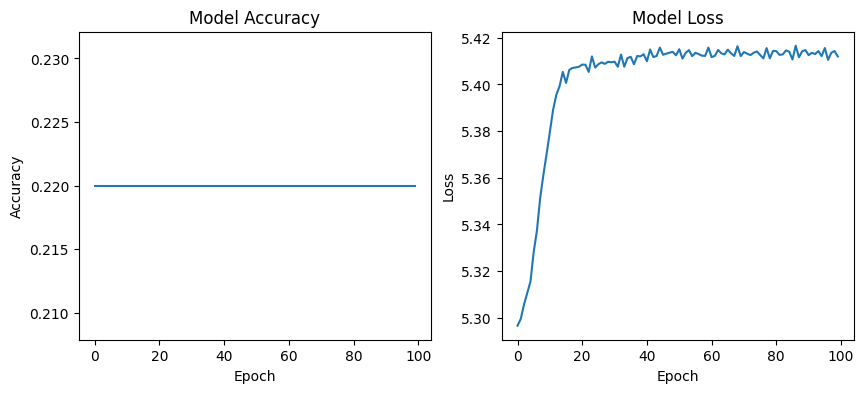

In [33]:
plot_metrics(history.history)

In [ ]:

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# # LSTM 모델 구축
# model = Sequential()
# model.add(Embedding(10000, 64, input_length=100))
# model.add(LSTM(128))
# model.add(Dense(5, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# from tensorflow.keras.layers import GRU

# # GRU 모델 구축
# model = Sequential()
# model.add(Embedding(10000, 64, input_length=100))
# model.add(GRU(128))
# model.add(Dense(5, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# BERT 모델 구현 예시 코드
